# Model Comparison for Revenue Prediction

This notebook compares different models for revenue prediction.

# Model Comparison for Revenue Prediction

This notebook compares different models for predicting revenue using our time series data. We'll evaluate:
- Linear Regression
- Random Forest
- XGBoost
- Prophet (Facebook's time series model)

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

Importing plotly failed. Interactive plots will not work.


## Data Loading and Preparation

Let's load our processed data and prepare it for modeling. We'll:
1. Load the CSV file
2. Check for missing values
3. Convert date columns to datetime
4. Create time-based features

## Load and Prepare Data

In [15]:
# Import required libraries
import pandas as pd
import numpy as np
from datetime import datetime
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns

# Fetch dataset
online_retail = pd.read_excel("../app/data/Online Retail.xlsx")



In [2]:

print("Dataset shape:", online_retail.shape)
print("\nFeature columns:", online_retail.columns.tolist())

Dataset shape: (541909, 8)

Feature columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


In [3]:
def preprocess_retail_data(df):
    # Make a copy
    df = df.copy()
    
    # Convert InvoiceDate to datetime
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    
    # Remove cancelled orders (those starting with 'C')
    df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
    
    # Remove missing values
    df = df.dropna(subset=['CustomerID'])
    
    # Calculate total amount for each transaction
    df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
    
    # Remove negative quantities and prices
    df = df[df['Quantity'] > 0]
    df = df[df['UnitPrice'] > 0]
    
    return df

# Preprocess the data
cleaned_data = preprocess_retail_data(online_retail)
print("Cleaned data shape:", cleaned_data.shape)

Cleaned data shape: (397884, 9)


In [5]:
def create_daily_aggregates(df):
    # Group by date
    daily_data = df.groupby(df['InvoiceDate'].dt.date).agg({
        'TotalAmount': 'sum',
        'Quantity': 'sum',
        'InvoiceNo': 'nunique',
        'CustomerID': 'nunique',
        'Country': 'nunique'
    }).reset_index()
    
    # Rename columns
    daily_data.columns = ['date', 'revenue', 'total_items', 
                         'num_transactions', 'num_customers', 'num_countries']
    
    # Convert date back to datetime
    daily_data['date'] = pd.to_datetime(daily_data['date'])
    
    # Sort by date
    daily_data = daily_data.sort_values('date')
    
    return daily_data

# Create daily aggregates
daily_data = create_daily_aggregates(cleaned_data)
print("Daily data shape:", daily_data.shape)
print("\nFirst few rows:")
print(daily_data.head())

Daily data shape: (305, 6)

First few rows:
        date   revenue  total_items  num_transactions  num_customers  \
0 2010-12-01  46376.49        24215               121             95   
1 2010-12-02  47316.53        31142               137             99   
2 2010-12-03  23921.71        11839                57             50   
3 2010-12-05  31771.60        16449                87             75   
4 2010-12-06  31215.64        16291                94             82   

   num_countries  
0              7  
1              3  
2             10  
3              5  
4              4  


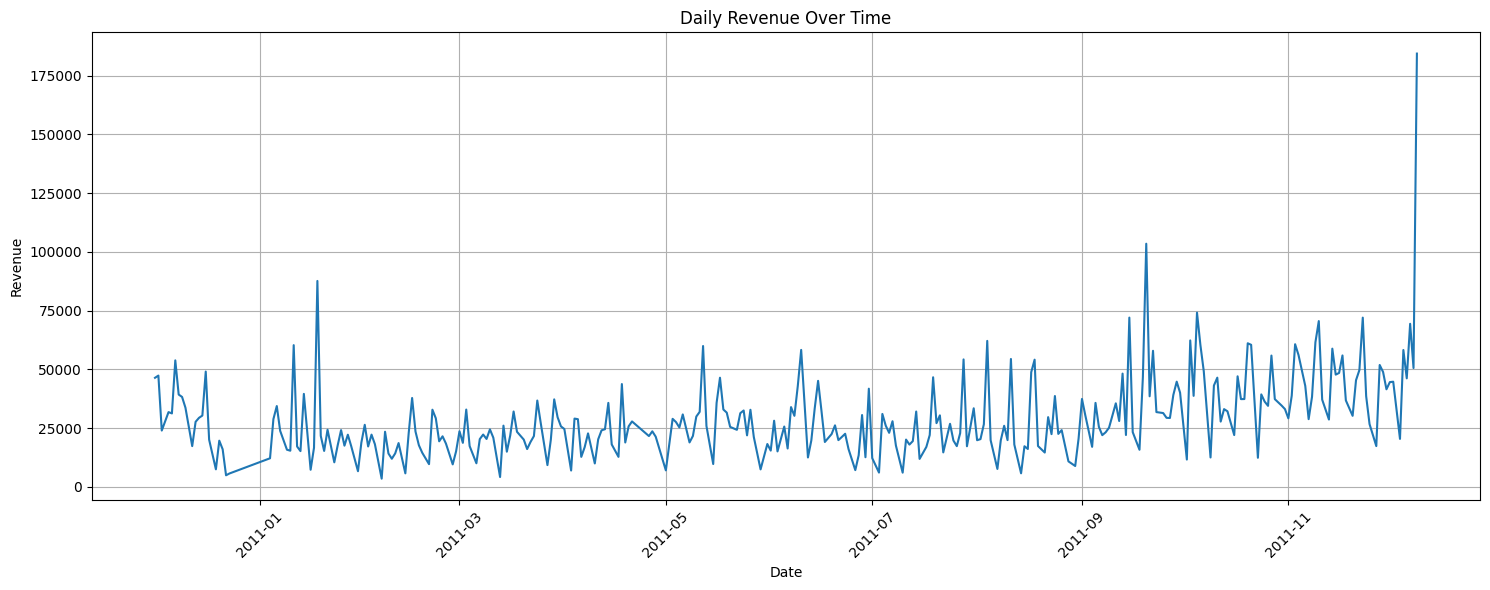

C:\Users\vansh\AppData\Local\Temp\ipykernel_26240\2451209789.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = daily_data.set_index('date').resample('M')['revenue'].sum()


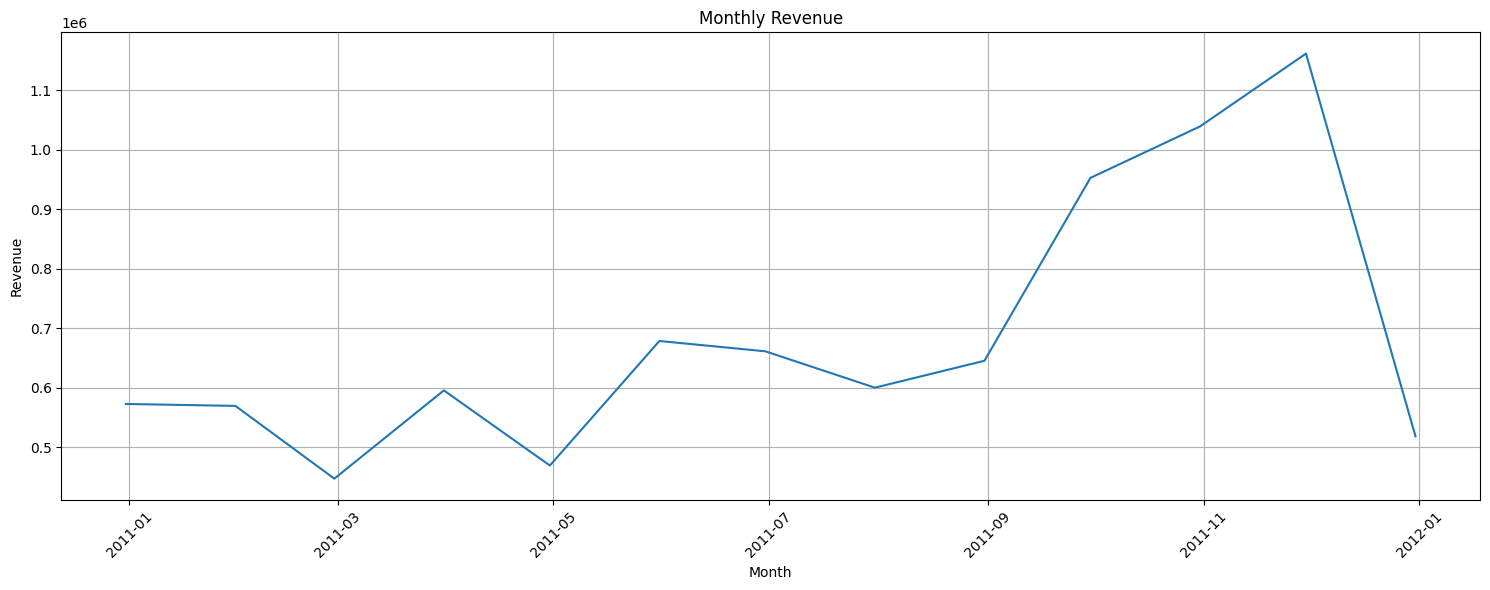

In [6]:
plt.figure(figsize=(15, 6))
plt.plot(daily_data['date'], daily_data['revenue'])
plt.title('Daily Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Monthly revenue
monthly_data = daily_data.set_index('date').resample('M')['revenue'].sum()
plt.figure(figsize=(15, 6))
plt.plot(monthly_data.index, monthly_data.values)
plt.title('Monthly Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
def create_features(df):
    df = df.copy()
    
    # Create date features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_month'] = df['date'].dt.day
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Create lag features
    for lag in [1, 7, 14, 30]:
        df[f'revenue_lag_{lag}'] = df['revenue'].shift(lag)
        df[f'transactions_lag_{lag}'] = df['num_transactions'].shift(lag)
        
    # Create rolling means
    for window in [7, 14, 30]:
        df[f'revenue_rolling_mean_{window}'] = df['revenue'].rolling(window=window).mean()
        df[f'transactions_rolling_mean_{window}'] = df['num_transactions'].rolling(window=window).mean()
    
    # Drop NaN values
    df = df.dropna()
    
    return df

# Create features
featured_data = create_features(daily_data)
print("Featured data shape:", featured_data.shape)
print("\nFeature columns:", featured_data.columns.tolist())



Featured data shape: (275, 25)

Feature columns: ['date', 'revenue', 'total_items', 'num_transactions', 'num_customers', 'num_countries', 'year', 'month', 'day_of_week', 'day_of_month', 'is_weekend', 'revenue_lag_1', 'transactions_lag_1', 'revenue_lag_7', 'transactions_lag_7', 'revenue_lag_14', 'transactions_lag_14', 'revenue_lag_30', 'transactions_lag_30', 'revenue_rolling_mean_7', 'transactions_rolling_mean_7', 'revenue_rolling_mean_14', 'transactions_rolling_mean_14', 'revenue_rolling_mean_30', 'transactions_rolling_mean_30']


In [12]:
def prepare_data(df):
    # Separate features and target
    X = df.drop(['revenue', 'date'], axis=1)
    y = df['revenue']
    
    # Create train/test split
    train_size = int(len(df) * 0.8)
    X_train = X[:train_size]
    X_test = X[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

X_train, X_test, y_train, y_test = prepare_data(featured_data)

In [13]:
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\nMetrics for {model_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2 Score: {r2:.2f}")
    
    return {'mse': mse, 'mae': mae, 'r2': r2}

# Train and evaluate models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate
    results[name] = evaluate_model(y_test, y_pred, name)


Metrics for Linear Regression:
MSE: 87455964.32
MAE: 4838.34
R2 Score: 0.84

Metrics for Random Forest:
MSE: 236760730.31
MAE: 6651.00
R2 Score: 0.57

Metrics for XGBoost:
MSE: 268939208.14
MAE: 7776.84
R2 Score: 0.51


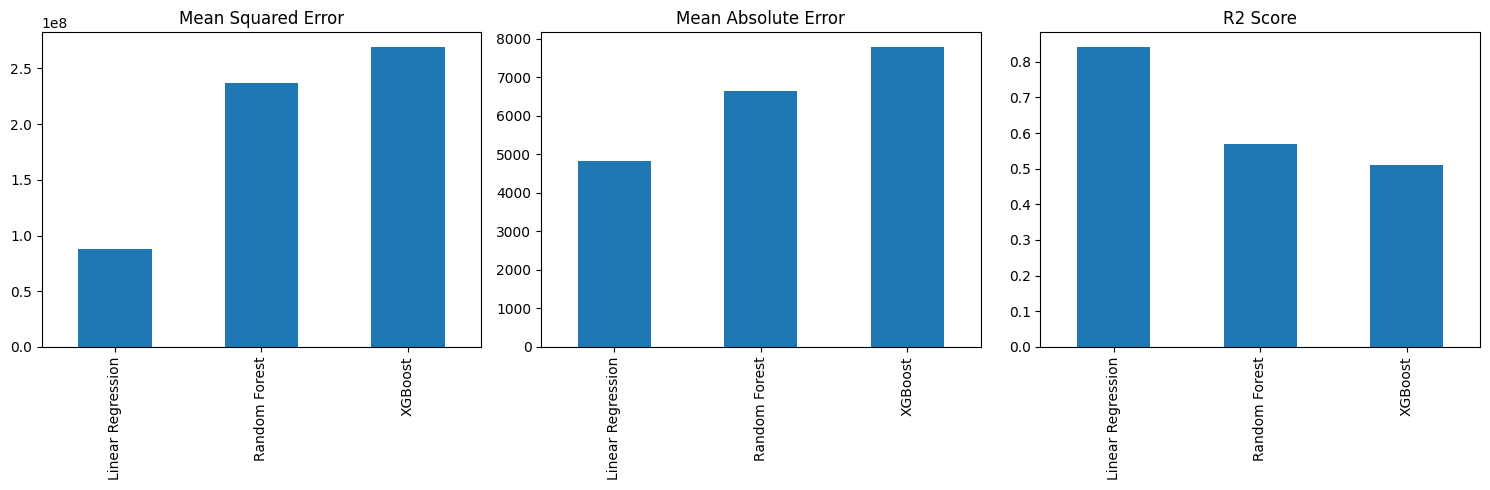

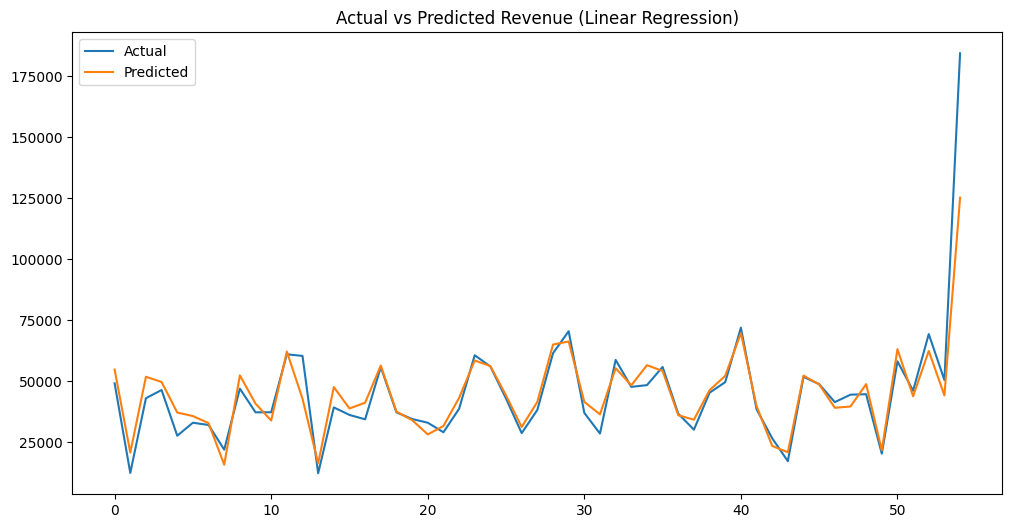

In [14]:
# Plot comparison of metrics
metrics_df = pd.DataFrame(results).T
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_df['mse'].plot(kind='bar', ax=axes[0], title='Mean Squared Error')
metrics_df['mae'].plot(kind='bar', ax=axes[1], title='Mean Absolute Error')
metrics_df['r2'].plot(kind='bar', ax=axes[2], title='R2 Score')

plt.tight_layout()
plt.show()

# Plot actual vs predicted for best model
best_model_name = metrics_df['r2'].idxmax()
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_best, label='Predicted')
plt.title(f'Actual vs Predicted Revenue ({best_model_name})')
plt.legend()
plt.show()

# Model Performance Analysis & Conclusion

## Model Comparison Summary
Based on the evaluation metrics and visualization results, here are the key findings:

### Linear Regression (Best Performer)
- Lowest Mean Squared Error (MSE): 87.4M
- Lowest Mean Absolute Error (MAE): 4,838.34
- Highest R² Score: 0.84 (84% variance explained)
- Shows the best predictive performance for revenue forecasting

### Random Forest
- Medium performance with MSE: 236.7M
- MAE: 6,651.00
- R² Score: 0.57 (57% variance explained)
- Shows some overfitting compared to Linear Regression

### XGBoost
- Highest MSE: 268.9M
- Highest MAE: 7,776.84
- Lowest R² Score: 0.51 (51% variance explained)
- Demonstrates potential overfitting issues

## Key Takeaways
1. Linear Regression outperforms more complex models, suggesting that the revenue patterns have a strong linear relationship with the features.
2. The simpler Linear Regression model achieves better generalization, with significantly lower error rates.
3. The actual vs predicted plot shows that Linear Regression captures the general trend well, though it slightly underestimates extreme peaks.

## Recommendations
1. Deploy the Linear Regression model for production use due to its:
  - Superior predictive performance
  - Lower complexity
  - Better interpretability
2. Consider feature engineering to improve Random Forest and XGBoost performance
3. Monitor model performance on new data, especially during peak revenue periods